# Point cloud based robotic milling toolpath generation for surface repair/defect correction

### Author: Chen Lequn
#### 26 Jan 2022

## **Notebook 4 (v2): robotic milling toolpath generation**

## Introduction
This notebook is to explore methodologies for robotic milling toolpath generation
- Point cloud clustering and segmentation
- Contour extraction
- machining toopath generation

## Set up

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import pandas as pd
import open3d as o3d
import numpy as np
import math

from shapely.geometry import Polygon
from shapely.geometry import MultiLineString, MultiPolygon
from shapely.geometry import LineString
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon,LinearRing, MultiPoint
from shapely import geometry
from shapely.ops import split

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
# %matplotlib auto
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = ".."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "png_images")
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "dataset")
XYZ_point_PATH = os.path.join(DATA_PATH, "xyz")
PCD_file_PATH = os.path.join(DATA_PATH, "pcd")
file_output_dir =  os.path.join(PROJECT_ROOT_DIR, "output_dir/surface_fitting_result")
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(file_output_dir, exist_ok=True)


## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import sys  
import os
import numpy as np
sys.path.insert(0, '../utils')

import utils_functions
from utils_functions import plot_line, plot_coords, color_isvalid, color_issimple, plot_line_isvalid, plot_line_issimple
from utils_functions import plot_bounds, add_origin, set_limits
from utils_functions import LinePolygonIntersectionPoints, sort_MultiPoint, LineInPolygonSegmentation, grid_line_creation, visualize_grid_line_generation
from utils_functions import reverse_MultiLineString, visualize_grid_polygon_segmentation, zig_zag_segmentation, visualize_grid_polygon_segmentation
from utils_functions import visualize_bulge_area, calculate_polygon_bondary_with_point_clusters, np_to_shapely, visualize_line_polygon_segmentation
from utils_functions import visualize_2D_DBSCAN
from ConcaveHull import ConcaveHull

In [3]:
import sys
sys.path.insert(0, '../pocketing-master')
import trimesh
import pocketing
import fiona

In [4]:
BLUE = '#6699cc'
GRAY = '#999999'
DARKGRAY = '#333333'
YELLOW = '#ffcc33'
GREEN = '#339933'
RED = '#ff3333'
BLACK = '#000000'

COLOR_ISVALID = {
    True: BLUE,
    False: RED,
}

### 1. Point cloud processing by Open3D library

#### 1.1  Step 1, obtain, convert the point cloud data into desired format
The accepted format for open3d library are ply, pcd, txt, ect. 
The best practice is using the __pcd__ file format as default, as the it is consistent with other program.

### File IO by open3d

In [5]:
## File IO
print("Testing IO for point cloud ...")

##--------------read point cloud data, save to a open3d object--------------
pcd = o3d.io.read_point_cloud(os.path.join(PCD_file_PATH, "30_seg_rot.pcd"))
# pcd = o3d.io.read_point_cloud(os.path.join(PCD_file_PATH, "point_cloud_example.pcd"))
print(pcd)

Testing IO for point cloud ...
PointCloud with 21798 points.


### voxel grid downsampling - to reduce the points

In [6]:
print("Downsample the point cloud with a voxel of 0.5")
downsample_pcd = pcd.voxel_down_sample(voxel_size=0.3)
# o3d.visualization.draw_geometries([downsample_pcd])

Downsample the point cloud with a voxel of 0.5


## 2. Point cloud visualizaiton by matplotlib

### - calculate the mean Z value (mean height of the top surface)

In [7]:
# ---- using numpy to print all the points -------
points_np_array = np.asarray(pcd.points)
print("the points converted to numpy are: \n")
print(points_np_array)
#------extract x,y,z value of the points-----
# ------------standarization-----------
# bbdiag = float(np.linalg.norm(points_np_array.max(0) - points_np_array.min(0), 2))
# points_np_array = (points_np_array - points_np_array.mean(0))/bbdiag
# print("the points are: \n")
# print(points_np_array)

scale = 1
x = points_np_array[:,0]* scale ## from m to mm
y = points_np_array[:,1]*scale  ## from m to mm
points_np_array[:,2] = points_np_array[:,2] - np.amin(points_np_array[:,2]) 
z = points_np_array[:,2]*scale  ## from m to mm
print("the z value extracted:" )
print (z)

# --------mean height-------------------
z_mean = np.mean(z)
print("Z mean: " + str(z_mean))

z_min = np.amin(z)
z_max = np.amax(z)
print ("Z minimum: "+ str(z_min))
print ("Z max: "+ str(z_max))


the points converted to numpy are: 

[[-13.84774583 -14.73133736   0.47270684]
 [-13.99546204 -14.56224483   0.48745801]
 [-14.10493174 -14.4094093    0.4682581 ]
 ...
 [ 12.0776545   13.18580701   1.68861493]
 [ 12.26074167  13.1871676    1.68418764]
 [ 11.68067066  13.40103275   1.7008424 ]]
the z value extracted:
[0.47270684 0.48745801 0.4682581  ... 1.68861493 1.68418764 1.7008424 ]
Z mean: 1.117028044460246
Z minimum: 0.0
Z max: 1.816255610021727


## Calculate the plane for segmentation

In [8]:
# tune the segmentation line
z_segment = z_max - 0.5

In [9]:
# Plot for a three-dimensional Plane
# this function is currently not used
def z_function(x, y):
    # ax+by+cz = d ---> z = -(ax+by-d)/c
    return  z_segment + 0 * x + 0 * y       

# create a plane with meshgrid (mainly for visualization purpose)
# x_plane = np.linspace(-11, 11, 30)
# y_plane = np.linspace(-21, 21, 30)
x_plane = np.linspace(-40, 40, 30)
y_plane = np.linspace(-40, 40, 30)

X, Y = np.meshgrid(x_plane, y_plane)
Z = z_function(X, Y) # the Z value (height) of the nominal plane is equal to the mean Z value of the point l
#print (X, Y, Z)


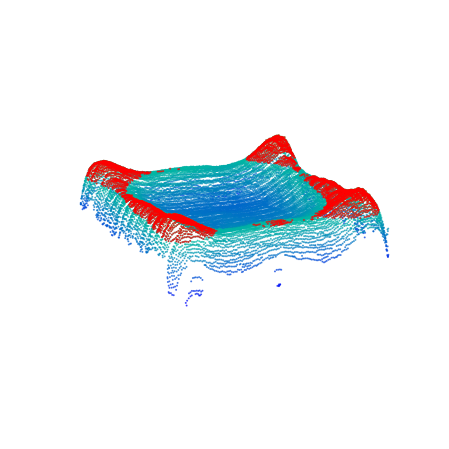

In [10]:
# this will make the plot interactive
# %matplotlib auto
x = points_np_array[:,0]
y = points_np_array[:,1]
points_np_array[:,2] = points_np_array[:,2] - np.amin(points_np_array[:,2]) 
z = points_np_array[:,2]


plt.figure(figsize=(16, 8))
# plt.figure()
ax = plt.axes(projection='3d')

### plot the wireframe
# ax.plot_wireframe(X, Y, Z, color='gray',  alpha=0.6)
# Data for three-dimensional scattered points, extracted from numpy array
# p = ax.scatter3D(x, y, z, c=z, cmap='winter', s = 5, alpha=0.6) # other cmap options: winter, Greens
ax.scatter3D(x, y, z, c=z, cmap='winter', s = 1, alpha=0.6)

points_new = points_np_array[((points_np_array[:,2] > (z_segment))),:]
x = points_new[:,0]
y = points_new[:,1]
z = points_new[:,2]
ax.scatter3D(x, y, z, c = 'r', s = 1, alpha=0.6)
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))
# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([0, 0.5, 1, 1.5, 2])
ax.set_zlim(-1.5, 3)
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)

# to hide the 3D axes
ax._axis3don = False

# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=20,azim=-22) #rotate the graph
# save_fig("02_visualization of 3D point cloud with the reference plane")

## Segmentation: Remove the points below the reference plane

the points below the reference plane are using numpy library

In [11]:
points_segmented = points_np_array[np.where(points_np_array[:,2] > z_segment)] # should be z_segment here

print(points_np_array)
print("the point cloud segmented: ")
print(points_segmented)

[[-13.84774583 -14.73133736   0.47270684]
 [-13.99546204 -14.56224483   0.48745801]
 [-14.10493174 -14.4094093    0.4682581 ]
 ...
 [ 12.0776545   13.18580701   1.68861493]
 [ 12.26074167  13.1871676    1.68418764]
 [ 11.68067066  13.40103275   1.7008424 ]]
the point cloud segmented: 
[[-11.73016925 -14.67086971   1.32607906]
 [-11.49780925 -14.65583685   1.31655   ]
 [-12.49975285 -14.52054742   1.3545    ]
 ...
 [ 12.0776545   13.18580701   1.68861493]
 [ 12.26074167  13.1871676    1.68418764]
 [ 11.68067066  13.40103275   1.7008424 ]]


Saving figure step3_point cloud below the reference plane


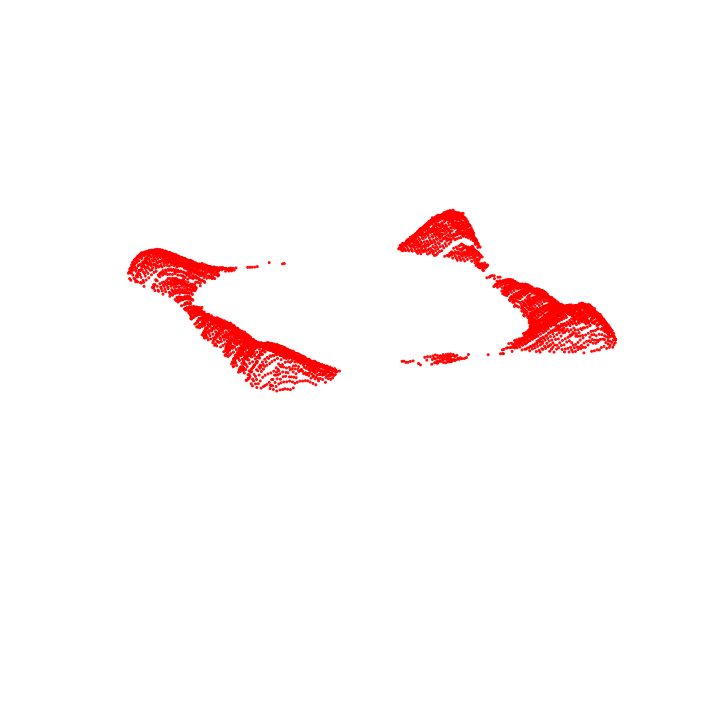

In [12]:
x_seg = points_segmented[:,0]
y_seg = points_segmented[:,1]
z_seg = points_segmented[:,2]



plt.figure(figsize=(10, 10))
# plt.figure()
ax = plt.axes(projection='3d')

# ax.plot_wireframe(X, Y, Z, color='gray', alpha = 0.6)
# Data for three-dimensional scattered points, extracted from numpy array
# p = ax.scatter3D(x_seg, y_seg, z_seg, c=z_seg, cmap = 'jet', s = 4, alpha = 0.9); # other cmap options: winter, Greens
p = ax.scatter3D(x_seg, y_seg, z_seg, c='r', s = 4, alpha = 0.9);
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))
# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([1, 1.5, 2])
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)

ax.set_zlim(-1.5, 3)
# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=20,azim=-20) #rotate the graph

ax._axis3don = False

save_fig("step3_point cloud below the reference plane")

In [13]:
print (points_segmented)

[[-11.73016925 -14.67086971   1.32607906]
 [-11.49780925 -14.65583685   1.31655   ]
 [-12.49975285 -14.52054742   1.3545    ]
 ...
 [ 12.0776545   13.18580701   1.68861493]
 [ 12.26074167  13.1871676    1.68418764]
 [ 11.68067066  13.40103275   1.7008424 ]]


## Extract the 2D projected points from the segmented cloud

the point cloud projected on the 2D plane: 
[[-11.73016925 -14.67086971   1.31625561]
 [-11.49780925 -14.65583685   1.31625561]
 [-12.49975285 -14.52054742   1.31625561]
 ...
 [ 12.0776545   13.18580701   1.31625561]
 [ 12.26074167  13.1871676    1.31625561]
 [ 11.68067066  13.40103275   1.31625561]]
point_extracted shape: (4993, 3)


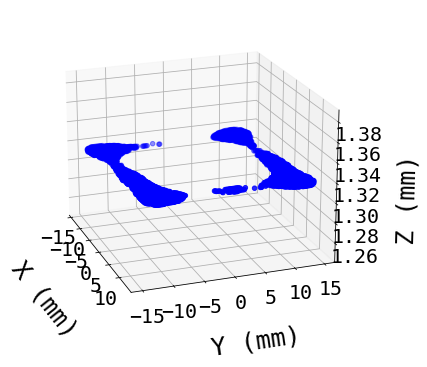

In [14]:
## set the z = z_segment for all the points
point_extracted = points_segmented
point_extracted[:,2] = z_segment
print("the point cloud projected on the 2D plane: ")
print(point_extracted)
print ("point_extracted shape: " + str(point_extracted.shape))


x_2d = point_extracted[:,0]
y_2d = point_extracted[:,1]
z_2d = point_extracted[:,2]



plt.figure(figsize=(6,6))
# plt.figure()
ax = plt.axes(projection='3d')


# ax.plot_wireframe(X, Y, Z, color='gray')
# Data for three-dimensional scattered points, extracted from numpy array
ax.scatter3D(x_2d, y_2d, z_2d, c=z_2d, cmap='winter'); # other cmap options: winter, Greens
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))
# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([1, 1.5, 2])
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)



# plt.title('point cloud projected onto the 2D reference plane')
ax.view_init(elev=20,azim=-20) #rotate the graph
#‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
# save_fig('step_4 point cloud projected onto the 2D reference plane')

## Convert all points into 2D points, remove the thrid dimension

In [15]:
print ("point_extracted number of points: " + str(point_extracted.shape[0]))
point_2D_extracted = np.zeros((point_extracted.shape[0], 2))
point_2D_extracted[:, 0] = point_extracted[:, 0]
point_2D_extracted[:, 1] = point_extracted[:, 1]
print ("point_2D_extracted dimensin: " + str(point_2D_extracted.shape))

point_extracted number of points: 4993
point_2D_extracted dimensin: (4993, 2)


## Using Sklearn DBSCAN clustering

In [16]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from matplotlib import transforms

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.8, min_samples=10).fit(point_2D_extracted)
# db = DBSCAN(eps=1, min_samples=10).fit(extracted_2D_downsampled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 18


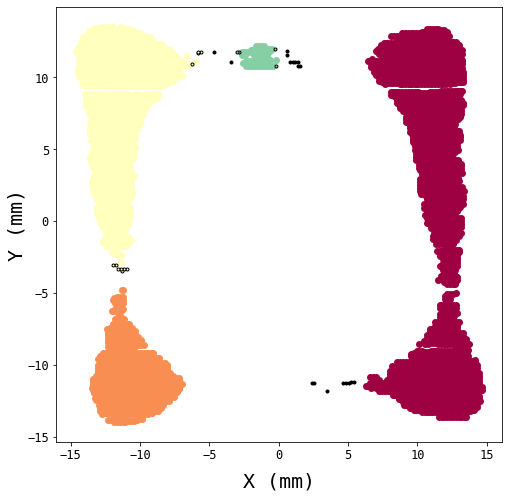

In [17]:
point_clusters = visualize_2D_DBSCAN(labels, n_clusters_, point_2D_extracted, core_samples_mask, save = False)

In [18]:
print("the dimension of the point cloud cluster: " + str(point_clusters[0].shape))

the dimension of the point cloud cluster: (2468, 2)


## Get the contour of each point cloud clusters

### Example : (from online)
https://stackoverflow.com/questions/23073170/calculate-bounding-polygon-of-alpha-shape-from-the-delaunay-triangulation

### Concave hull (polygon fitting) based on Python Shapely

- Hyperparameter for tuning: tolerance (equivalent to alpha value)

### plot the whole picture edges (polygon boundary) with point cloud clusters and bounding box

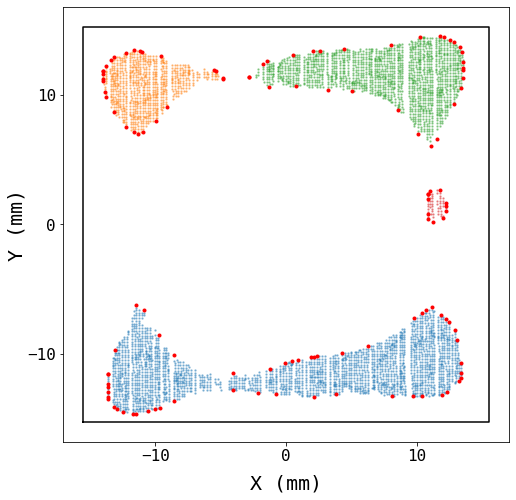

In [19]:
# return a list of points define cluster boundary
interior_boundary_points = calculate_polygon_bondary_with_point_clusters(point_clusters)

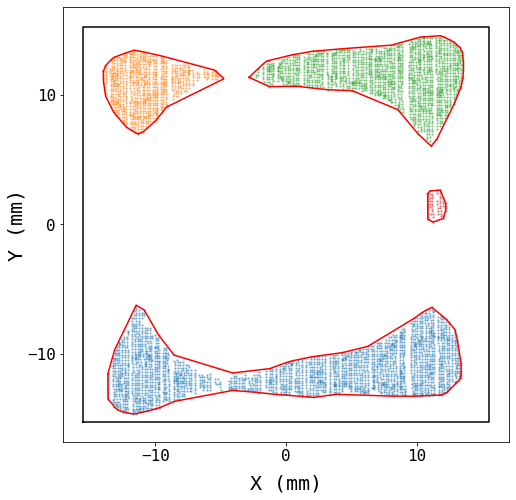

In [20]:
interior_boundary_points = calculate_polygon_bondary_with_point_clusters(point_clusters, lines = True, tolerance = 5)

In [21]:
type(interior_boundary_points)

list

# Tool path generation

## __figures.py__ -- an utility function downloaded from shapely.figures.py

https://raw.githubusercontent.com/Toblerity/Shapely/master/docs/code/figures.py

## Testing with our example -- Plot the polygon with clustered bulge area as holes

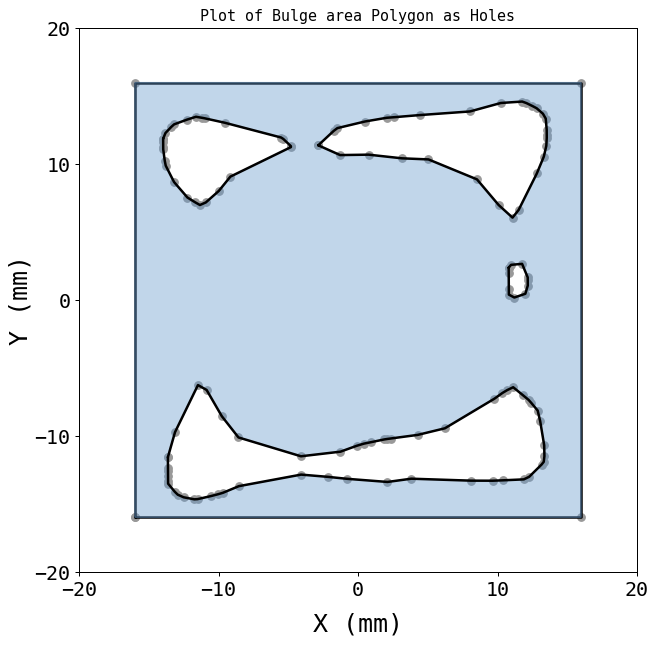

In [22]:
# Define exterior boundary CCW direction
# ext = [(-10.5, -20.5), (10.5, -20.5), (10.5, 20.5), (-10.5, 20.5), (-10.5, -20.5)]
ext = [(-16, -16), (16, -16), (16, 16), (-16, 16), (-16, -16)]
polygon = visualize_bulge_area(interior_boundary_points, ext)

### Import Shapely Polygon into files using fiona library (not used for now)
- https://gis.stackexchange.com/questions/20734/python-how-to-export-shapely-objects-to-dxf-file
- https://github.com/Toblerity/Fiona

In [23]:
# import fiona
# with fiona.collection("file.shp", "r") as source:
#     with fiona.collection(
#             "polygon.dxf",
#             "w",
#             driver="DXF",
#             schema=source.schema,
#             ) as sink:

#         # Do whatever you like to records
#         # results = some_function(source)

#         sink.writerecords(polygon)

In [24]:
# from shapely.geometry import mapping
# import json
# open("polygon.geojson", "wb").write(json.dumps(mapping(polygon)))

In [25]:
# !ogr2ogr -f DXF buffer.dxf buffer.geojson

## Important open-source implementations for toolpath generation algorithms
- __trimesh__: Python library for loading and using triangular meshes. [github](https://github.com/mikedh/trimesh)
     - Up-to-date, 1.7k, widely used.
     - well tested Trimesh object which allows for easy manipulation and analysis, in the style of the Polygon object in the Shapely library.
- __pocketing__: Fill 2D regions with traversals for generating tool paths [github](https://github.com/mikedh/pocketing)
     - easy to use, but less stable and not well maintained
     - build upon trimesh
     - Accept shapely.geometry.Polygon objects as input
     - Generate toolpath output as a sequence of (n, 2) float arrays
     - Collision check and calculate feed rates using raster checks

### Toolpath generation usinng pocketing python library

#### convert interior bulge area into a multipolygon object

In [26]:
polygon_list = []
for i in range(len(interior_boundary_points)):
    polygon_list.append( Polygon(interior_boundary_points[i][::-1]) )

In [27]:
multi_poly = MultiPolygon(polygon_list)

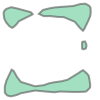

In [28]:
multi_poly

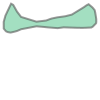

In [29]:
polygon_list[0]

trimesh functionalites of format conversions (dxf file, shapely object, etc)
- https://trimsh.org/trimesh.path.exchange.misc.html
- https://trimsh.org/trimesh.path.exchange.dxf.html
- https://trimsh.org/trimesh.path.exchange.misc.html

In [30]:
path_multi_poly = trimesh.path.exchange.misc.polygon_to_path(multi_poly)
path_polygon = trimesh.path.exchange.misc.polygon_to_path(polygon)
# DXF_path_polygon = trimesh.path.exchange.dxf.export_dxf(path_polygon, only_layers=None)

In [31]:
# path_multi_poly['entities'][0]
# path_multi_poly

In [32]:
path_multi_poly_converted = trimesh.path.Path2D(entities=path_multi_poly['entities'], vertices=path_multi_poly['vertices'])
path_polygon_converted = trimesh.path.Path2D(entities=path_polygon['entities'], vertices=path_polygon['vertices'])

In [33]:
poly_converted = path_polygon_converted.polygons_full[0]

In [34]:
path_polygon_converted.plot_entities

<bound method Path2D.plot_entities of <trimesh.Path2D(vertices.shape=(122, 2), len(entities)=5)>>

In [35]:
# path_load = trimesh.load('../pocketing-master/models/wrench.dxf')
# poly_example = path_load.polygons_full[0]

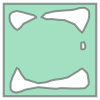

In [36]:
poly_converted

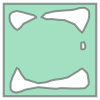

In [37]:
polygon

In [38]:
print (polygon.exterior.coords[0])
print (polygon_list[0].exterior.coords[0])
print (poly_converted.exterior.coords[0])

(-16.0, -16.0)
(-13.627052976873532, -11.566809840897484)
(-16.0, -16.0)


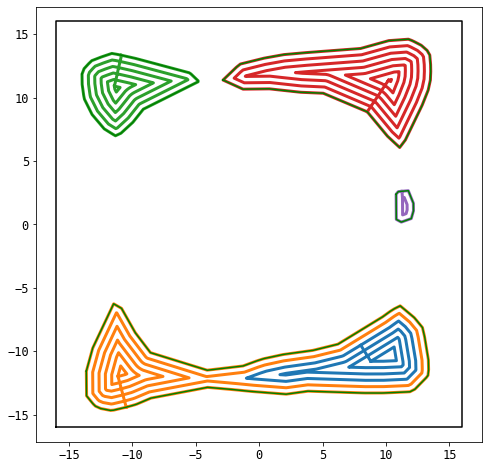

In [39]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
toolpaths = []
for polygons in polygon_list:
    toolpath = pocketing.contour.contour_parallel(polygons, step=0.5)
    for element in toolpath:
        toolpaths.append(element)
    
# visualize by plotting
for tool in toolpaths:
    plt.plot(*tool.T, linewidth = 3)
path_polygon_converted.show()

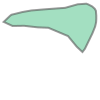

In [40]:
polygon_list[2]
# poly_converted

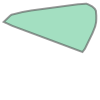

In [41]:
cuttable = pocketing.polygons.cuttable(polygon_list[2], radius = 0.01, debug = True)
cuttable

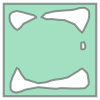

In [42]:
poly_converted

## Cover Polygon's Oriented Bounding Box  (OBB) with zigzag toolpath

In [43]:
polygon_selected = polygon_list[2]

<class 'numpy.ndarray'>
shape
(32, 2)


Text(0, 0.5, 'Y (mm)')

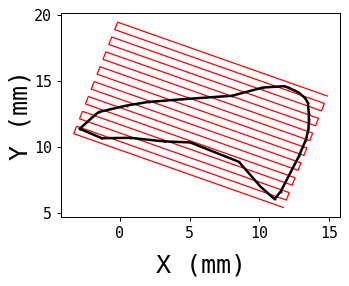

In [78]:
fig = plt.figure(1,figsize=(4,3), dpi=90)
ax = plt.axes()
path_grid_cover, rotation, extents = pocketing.grid.cover(polygon_selected, step = 1)

print(type(path_grid_cover))
print ("shape")
print (path_grid_cover.shape)

plt.plot(*path_grid_cover.T,color='r', linestyle='-', linewidth = 1)

# path_polygon_converted.show()
#----------------------plot the polygon------------------------------
plot_line(ax, ob=polygon_selected.exterior, color=BLACK, zorder=5, linewidth=2, alpha=1)
for i in range(len(polygon_selected.interiors)):
    plot_line(ax, ob=polygon_selected.interiors[i], color=BLACK, zorder=5, linewidth=2, alpha=1)

plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
# plt.xticks([-10, 0, 10], fontsize = 16) 
# plt.xticks([ -10, 0 , 10, 20], fontsize = 16)
# plt.yticks([ 0 , 10, 20], fontsize = 16)
# path_polygon_converted.show()

[[11.70788495  5.41988653]
 [-3.2857124  11.00486984]
 [-0.14415929 19.43876835]
 [14.84943806 13.85378504]
 [11.70788495  5.41988653]]


Text(0, 0.5, 'Y (mm)')

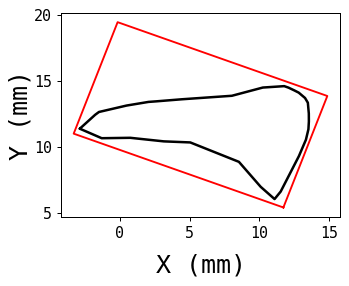

In [86]:
fig = plt.figure(1,figsize=(4,3), dpi=90)
ax = plt.axes()

# lower_right = path_grid_cover[0,0], path_grid_cover[0,1]
bounding_box = np.zeros((5,2))
bounding_box[0,:] = path_grid_cover[0,:]
bounding_box[1,:] = path_grid_cover[1,:]
bounding_box[2,:] = path_grid_cover[-2,:]
bounding_box[3,:] = path_grid_cover[-1,:]
bounding_box[4,:] = path_grid_cover[0,:]
print (bounding_box)
plt.plot(bounding_box[:,0], bounding_box[:,1], 'r')

# path_polygon_converted.show()
#----------------------plot the polygon------------------------------
plot_line(ax, ob=polygon_selected.exterior, color=BLACK, zorder=5, linewidth=2, alpha=1)
for i in range(len(polygon_selected.interiors)):
    plot_line(ax, ob=polygon_selected.interiors[i], color=BLACK, zorder=5, linewidth=2, alpha=1)

plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)

In [45]:
# type(extents)
extents.shape

(2,)

In [46]:
extents = np.append(extents, 0)
print (extents.shape)

(3,)


In [47]:
print ("Original rotation")
print (rotation)

y = np.array([[0], [0], [0]]) 
rotation = np.append(rotation, y, axis=1)
print ("after")
print (rotation)

y = np.array([[0,0,0,1]])
rotation = np.append(rotation, y, axis=0)
print ("after")
print (rotation)
p = trimesh.creation.box(extents=extents, transform=rotation)

Original rotation
[[  0.93709983  -0.34906146  -1.07958356]
 [  0.34906146   0.93709983 -13.66574615]
 [  0.           0.           1.        ]]
after
[[  0.93709983  -0.34906146  -1.07958356   0.        ]
 [  0.34906146   0.93709983 -13.66574615   0.        ]
 [  0.           0.           1.           0.        ]]
after
[[  0.93709983  -0.34906146  -1.07958356   0.        ]
 [  0.34906146   0.93709983 -13.66574615   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]


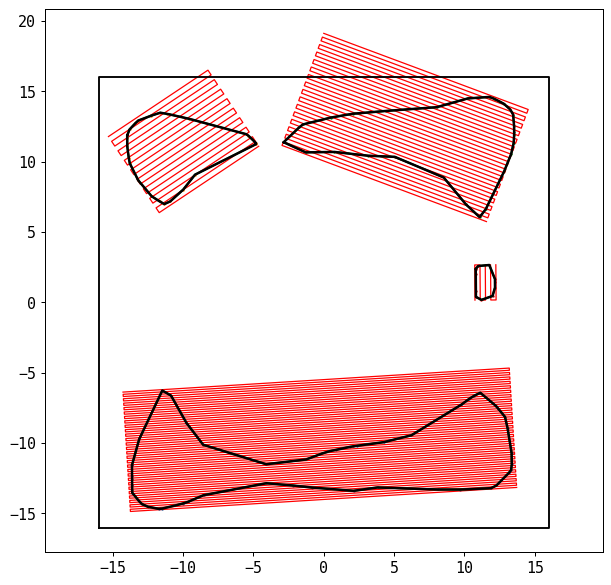

In [90]:
fig = plt.figure(1,figsize=(8,8), dpi=90)
ax = plt.axes()
for polygon_selected in polygon_list:
    path_grid_cover, rotation, extent = pocketing.grid.cover(polygon_selected, step = 0.5)
    plt.plot(*path_grid_cover.T,color='r', linestyle='-', linewidth = 1)
    # path_polygon_converted.show()
    #----------------------plot the polygon------------------------------
    plot_line(ax, ob=polygon_selected.exterior, color=BLACK, zorder=5, linewidth=2, alpha=1)
    for i in range(len(polygon_selected.interiors)):
        plot_line(ax, ob=polygon_selected.interiors[i], color=BLACK, zorder=5, linewidth=2, alpha=1)
path_polygon_converted.show()

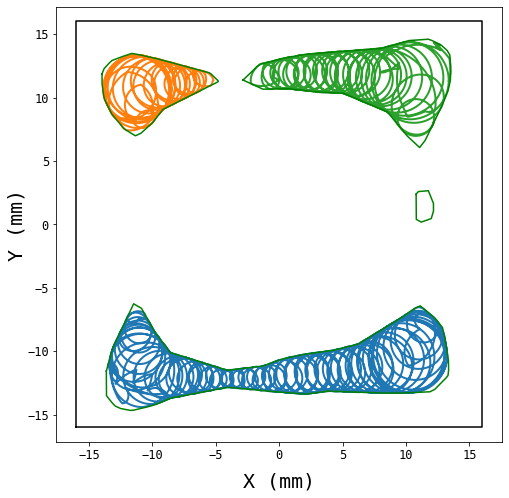

In [91]:
# radius = .125
# step = radius * 0.75
radius = 0.7
step = radius * 1.2

fig = plt.figure(figsize=(8, 8))
ax = plt.axes()

for polygon in polygon_list:
    toolpath = pocketing.trochoidal.toolpath(polygon,step=step)
    plt.plot(*toolpath.T, linewidth = 2)
    
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)

path_polygon_converted.show()


# plt.xticks(np.arange(-10, 10, 10))
# plt.xticks([-10, 0, 10], fontsize = 16) 
# plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)
# # ax.set_title('Plot of Bulge area Polygon as Holes')
# plt.show()

In [92]:
# radius = .125
# step = radius * 0.75

# toolpath = pocketing.trochoidal.toolpath(poly_example,step=step)

# plt.plot(*toolpath.T)
# path_load.show()

In [93]:
# path_load.show()

In [94]:
# anim = pocketing.visualize.animate_path(polygon_list[0], toolpath)  

In [95]:
# anim.save("toolpath.mp4")

<!-- ### convert the interior boundary points to a MultiPolygon object -->

In [96]:
# multiPolygon = MultiPolygon(interior_boundary_points) 

In [97]:
type(interior_boundary_points[0])

numpy.ndarray

In [98]:
# line_string = geometry.asLineString(points_segmented)
polygon_3D = geometry.Polygon(np.squeeze(points_np_array))
polygon_seg_3D = geometry.Polygon(points_segmented)

In [99]:
# polygon_3D

In [100]:
# polygon_seg_3D

In [101]:
polygon_2D_extracted_raw = geometry.Polygon(point_2D_extracted) 
# polygon_2D_extracted_raw

Access the members of a MultiLineString object

- Its members are instances of LineString and are accessed via the geoms property or via the iterator protocol using in or list().